<a href="https://colab.research.google.com/github/maledias/dogs-vs-cats/blob/main/dogs_vs_cats_without_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando CNNs para classificar imagens reais de cachorros e gatos

O objetivo deste notebook é criar um modelo capaz de classificar imagens de cachorros e gatos do dataset "Dogs vs. Cats".

As imagens podem ser de diferentes tamanhos, com diferentes objetos, por isso será necessário processar as imagens para aumentar a eficácia do modelo.

## Explorando o banco de dados

Embora o dataset seja composto por 25000 imagens, serão utilizadas apenas um subconjunto dessas imagens, com o objetivo de acelerar o tempo de treino.

### Baixando as imagens

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-09-21 15:01:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  43.1MB/s    in 1.5s    

2021-09-21 15:01:07 (43.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Descompactando os arquivos

In [3]:
import zipfile

downloaded_zip = '/tmp/cats_and_dogs_filtered.zip'

with zipfile.ZipFile(downloaded_zip, 'r') as f:
    f.extractall('/tmp')

Criando variáveis para representar os diretórios:   

In [4]:
train_dir = '/tmp/cats_and_dogs_filtered/train'
val_dir = '/tmp/cats_and_dogs_filtered/validation'
train_dogs_dir = '/tmp/cats_and_dogs_filtered/train/dogs'
train_cats_dir = '/tmp/cats_and_dogs_filtered/train/cats'
val_dogs_dir = '/tmp/cats_and_dogs_filtered/validation/dogs'
val_cats_dir = '/tmp/cats_and_dogs_filtered/validation/cats'

Quantidade de exemplos em cada diretório:

In [5]:
import os

train_dogs_fnames = os.listdir(train_dogs_dir)
val_dogs_fnames = os.listdir(val_dogs_dir)
train_cats_fnames = os.listdir(train_cats_dir)
val_cats_fnames = os.listdir(val_cats_dir)

print("CATS")
print("Training images: ", len(train_cats_fnames))
print("Validation images: ", len(val_cats_fnames))
print("\n")
print("DOGS:")
print("Training images: ", len(train_dogs_fnames))
print("Validation images: ", len(val_dogs_fnames))

CATS
Training images:  1000
Validation images:  500


DOGS:
Training images:  1000
Validation images:  500


São 1000 imagens de treino para cada classe e 500 imagens de validação para cada classe.

### Visualizando as imagens

Visualização de algumas imagens (cada vez que a célula é executada, um novo conjunto de imagens é mostrado):

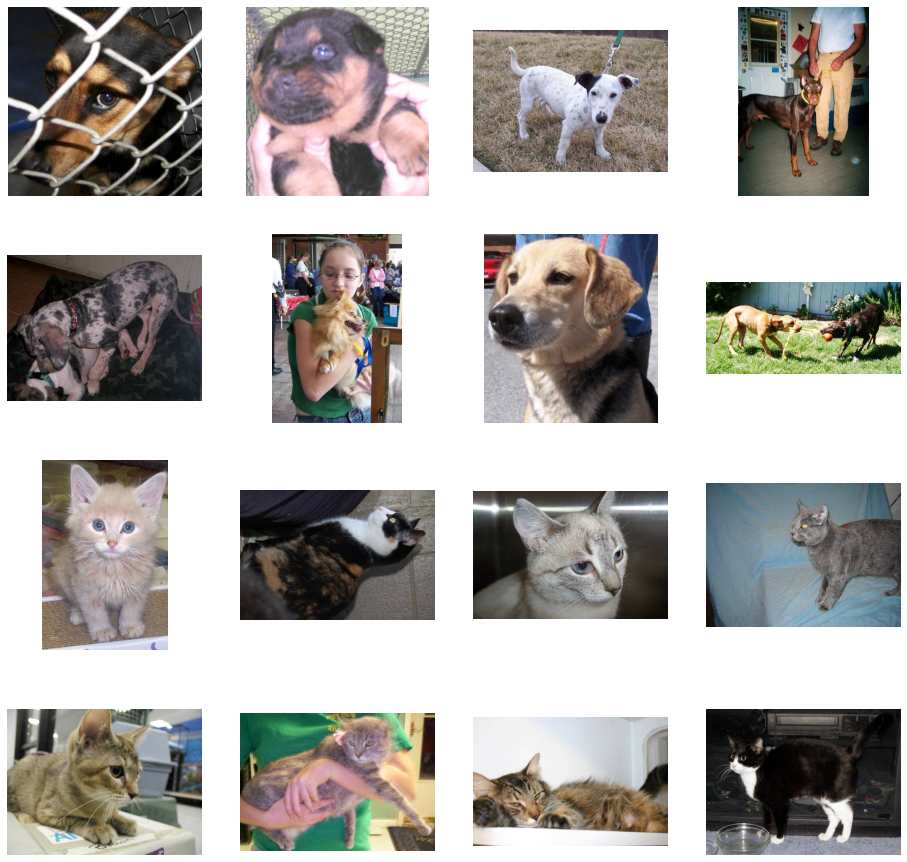

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

index = random.randint(0, 992)
fig = plt.gcf()
fig.set_size_inches(16, 16)
dog_images = [os.path.join(train_dogs_dir, filename) 
    for filename in train_dogs_fnames[index:index+8]]
cat_images = [os.path.join(train_cats_dir, filename) 
    for filename in train_cats_fnames[index:index+8]]

for i, img_path in enumerate(dog_images+cat_images):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Criando o modelo

In [7]:
import tensorflow as tf

print(tf.__version__)

2.6.0


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')                               
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

## Preprocessando os dados

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 20

train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    target_size=(150, 150),
    class_mode='binary',
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=BATCH_SIZE,
    target_size=(150, 150),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Treinando o modelo

In [11]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_steps=50,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 43s 107ms/step - loss: 0.9473 - accuracy: 0.5675 - val_loss: 0.8028 - val_accuracy: 0.5210
Epoch 2/5
100/100 [==============================] - 10s 105ms/step - loss: 0.6795 - accuracy: 0.6615 - val_loss: 0.5964 - val_accuracy: 0.6870
Epoch 3/5
100/100 [==============================] - 10s 105ms/step - loss: 0.5790 - accuracy: 0.7000 - val_loss: 0.5883 - val_accuracy: 0.6810
Epoch 4/5
100/100 [==============================] - 10s 105ms/step - loss: 0.4984 - accuracy: 0.7645 - val_loss: 0.5650 - val_accuracy: 0.7230
Epoch 5/5
100/100 [==============================] - 11s 105ms/step - loss: 0.4115 - accuracy: 0.8055 - val_loss: 0.6207 - val_accuracy: 0.7200


## Validação do modelo

No handles with labels found to put in legend.


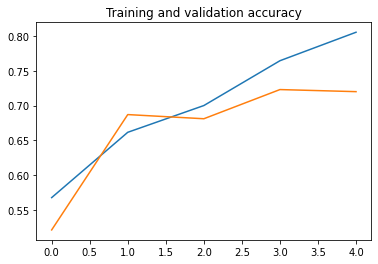

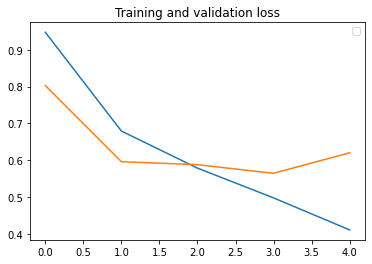

In [15]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot  (epochs, acc)
plt.plot  (epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  (epochs,loss)
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss')
plt.legend()
